# VAR Modeling

## Import libraries and read in data

In [425]:
#Import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
warnings.filterwarnings("ignore")

In [426]:
# Reading in saved dataframe from 1_EDA_DC_Covid.ipynb and 2_Feature_Engineering.ipynb
model_df = pd.read_csv('./Data/model_df.csv')

# Setting Date index
model_df['Date'] = pd.to_datetime(model_df['Date'])
model_df.set_index('Date', inplace=True)
model_df.sort_index(inplace=True)
model_df.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases,Avg_Temp
Date,,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0,47.6
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0,54.0
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0,56.8
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0,54.4
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0,57.1


### ADF Testing

In [427]:
# Function infers whether data is stationary according to the p-value extracted from Augmented Dickey Fuller test

def get_p_value_adfuller(df, alpha=0.05):
    
    for col in df.columns:
        
        dftest = adfuller(df[col])
    
        if dftest[1] >= alpha:
            print(f'The p-value for {col} is {round(dftest[1], 4)}, which is greater than alpha {alpha}. Infer that the data is not stationary.')
           
        else:
            print(f'The p-value for {col} is {round(dftest[1], 4)}, which is smaller than alpha {alpha}. Infer that the data is stationary.')

In [430]:
# None of the variables from the original model_df dataframe appear stationary from the ADF test
get_p_value_adfuller(model_df)

The p-value for Ward_1_Cases is 0.7378, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Ward_2_Cases is 0.8803, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Ward_3_Cases is 0.9783, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Ward_4_Cases is 0.7039, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Ward_5_Cases is 0.5384, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Ward_6_Cases is 0.9821, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Ward_7_Cases is 0.8834, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Ward_8_Cases is 0.9055, which is greater than alpha 0.05. Infer that the data is not stationary.
The p-value for Avg_Temp is 0.9321, which is greater than alpha 0.05. Infer that the data is not

In [431]:
# The ADF test results infer that differencing the dataframe once makes all variables stationary. 
# Due to this result, I will assign all ARIMAX models d = 1 to indicate a one-time differencing of the data.
get_p_value_adfuller(model_df.diff().dropna())

The p-value for Ward_1_Cases is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Ward_2_Cases is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Ward_3_Cases is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Ward_4_Cases is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Ward_5_Cases is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Ward_6_Cases is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Ward_7_Cases is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Ward_8_Cases is 0.0016, which is smaller than alpha 0.05. Infer that the data is stationary.
The p-value for Avg_Temp is 0.0, which is smaller than alpha 0.05. Infer that the data is stationary.


In [432]:
# Creating a new dataframe with differenced values of model_df
model_df_diff = model_df.diff().dropna()

In [434]:
# Splitting the model_df_sc data into train and test datasets
train, test = train_test_split(model_df_diff, train_size = 0.85, shuffle = False)

In [435]:
train.columns

Index(['Ward_1_Cases', 'Ward_2_Cases', 'Ward_3_Cases', 'Ward_4_Cases',
       'Ward_5_Cases', 'Ward_6_Cases', 'Ward_7_Cases', 'Ward_8_Cases',
       'Avg_Temp'],
      dtype='object')

In [436]:
train_endog = train.drop(columns='Avg_Temp') 
train_exog = train['Avg_Temp']

test_endog = test.drop(columns='Avg_Temp') 
test_exog = test['Avg_Temp']

In [437]:
# Instantiate and fit VAR model, using AIC to select p

var_model = VAR(endog = endog, 
                exog = exog,
                freq='D')
fitted_model = var_model.fit(ic='aic', maxlags=2)

In [438]:
# Making a list of rolling predictions
predictions = []
history_endog = train_endog.values.tolist()
history_exog = train_exog.values.tolist()
test_endog_vals = test_endog.values.tolist()
test_exog_vals = test_exog.values.tolist()

for t in range(len(test)):

            var_model = VAR(endog = train_endog, 
            exog = train_exog,
            freq='D')
            fitted_model = var_model.fit(ic='aic', maxlags=2)

            yhat = fitted_model.forecast(history_endog, 
                                         steps=len(test), exog_future = test_exog_vals)[0]

            predictions.append(yhat.tolist())
            history_endog.append(test_endog_vals[t])
            history_exog.append(test_exog_vals[t])
predictions = np.array(predictions)

In [439]:
# Turning predictions into a DataFrame
predictions = pd.DataFrame(predictions, index=test.index, 
                           columns=['Ward_1_Preds', 'Ward_2_Preds', 'Ward_3_Preds', 'Ward_4_Preds',
       'Ward_5_Preds', 'Ward_6_Preds', 'Ward_7_Preds', 'Ward_8_Preds'])

In [441]:
# Function that reverts back the differencing to get the forecast to original scale.
# Some code is derived from Selva Prabhakaran's VAR Guide on machinelearningplus.com, linked in Sources.
def invert_transformation(train, df_forecast):
    df_inv = df_forecast.copy()
    for ward in range(1, 9):  
        
        # Roll back 1st Diff
        df_inv[f'Ward_{str(ward)}_Forecast'] = train[f'Ward_{str(ward)}_Cases'].iloc[-1] + df_inv[f'Ward_{str(ward)}_Preds'].cumsum()
        
    df_results = df_inv.loc[:, ['Ward_1_Forecast', 'Ward_2_Forecast', 'Ward_3_Forecast', 'Ward_4_Forecast',
       'Ward_5_Forecast', 'Ward_6_Forecast', 'Ward_7_Forecast', 'Ward_8_Forecast']]
    
    return df_results

In [442]:
# Function gets RMSE scores by list of Ward numbers
def get_rmse_scores(test, preds, ward_list):
        
    for ward in ward_list:
                
        rmse_forecast = mean_squared_error(model_df[f'Ward_{str(ward)}_Cases'][test.index[0]:test.index[-1]],
                                           preds[f'Ward_{str(ward)}_Forecast'], 
                                           squared=False)
        print(f'RMSE for Ward {str(ward)} is {rmse_forecast}')
        print()

In [443]:
# Converting the prediction values to the pre-differenced state 
undifferenced_preds = invert_transformation(train = model_df[train.index[0]:train.index[-1]],
                                            df_forecast = predictions)
undifferenced_preds.head()

,Ward_1_Forecast,Ward_2_Forecast,Ward_3_Forecast,Ward_4_Forecast,Ward_5_Forecast,Ward_6_Forecast,Ward_7_Forecast,Ward_8_Forecast
Date,,,,,,,,
2020-12-06,38.031987,27.551836,18.282151,43.154063,48.686104,50.938471,51.123637,33.515135
2020-12-07,36.463528,34.819542,14.787789,36.172503,55.191968,68.615982,65.349278,40.931652
2020-12-08,24.708916,30.687736,14.837584,39.149976,48.063300,58.466406,53.733517,29.952366
2020-12-09,27.148575,37.250681,10.301550,37.953219,52.345383,62.624705,60.894298,28.811185
2020-12-10,36.123073,38.067787,16.167885,46.237521,47.454283,54.831778,55.343353,26.257471


In [444]:
# Getting RMSE using the undifferenced predictions and the original undifferenced dataframe's 
# values during the same time range (test period).
get_rmse_scores(model_df[test.index[0]:test.index[-1]], undifferenced_preds, [1, 2, 3, 4, 5, 6, 7, 8])

RMSE for Ward 1 is 14.70103682504

RMSE for Ward 2 is 15.249690891829653

RMSE for Ward 3 is 11.088836349474494

RMSE for Ward 4 is 14.66760132000999

RMSE for Ward 5 is 18.530462801052252

RMSE for Ward 6 is 26.95003849862492

RMSE for Ward 7 is 25.829910888494407

RMSE for Ward 8 is 16.68159306444074



In [445]:
def plot_test_vs_pred(train, test, ward_no, preds):
    
    actual_train = model_df[f'Ward_{str(ward_no)}_Cases'][train.index[0]:train.index[-1]]
    actual_test = model_df[f'Ward_{str(ward_no)}_Cases'][test.index[0]:test.index[-1]]
    
    plt.figure(figsize=(14, 4))
    
    plt.plot(actual_train)
    plt.plot(actual_test)
    plt.plot(preds[f'Ward_{str(ward_no)}_Forecast'])
    plt.ylabel('Daily Cases', fontsize=14)
    plt.legend(['Train Values', 'Actual Values', 'Predictions'], loc='upper left')
    plt.title(f'Ward {str(ward_no)}: Daily Case Predictions vs Actual', fontsize=16)
    
    plt.tight_layout();

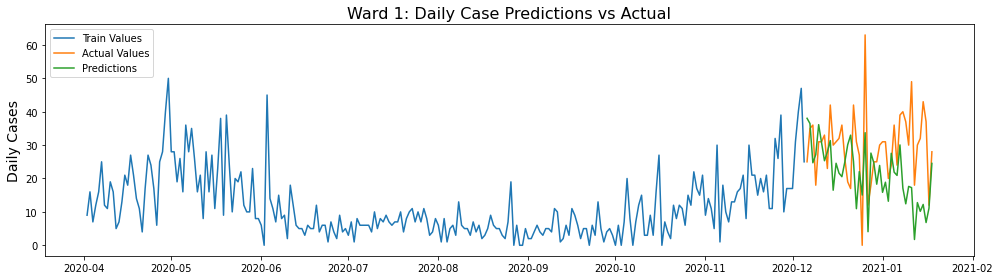

In [446]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 1, 
                  preds=undifferenced_preds)

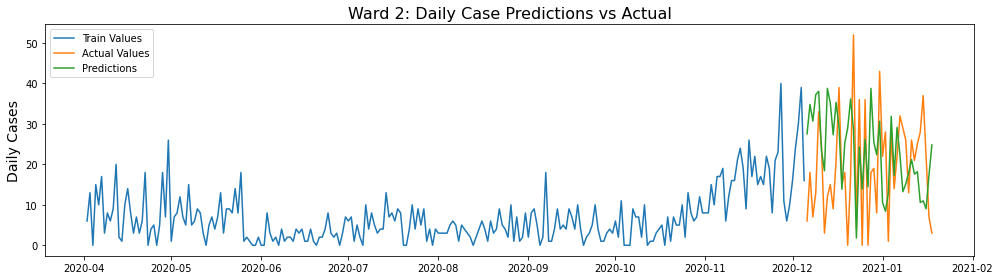

In [447]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 2, 
                  preds=undifferenced_preds)

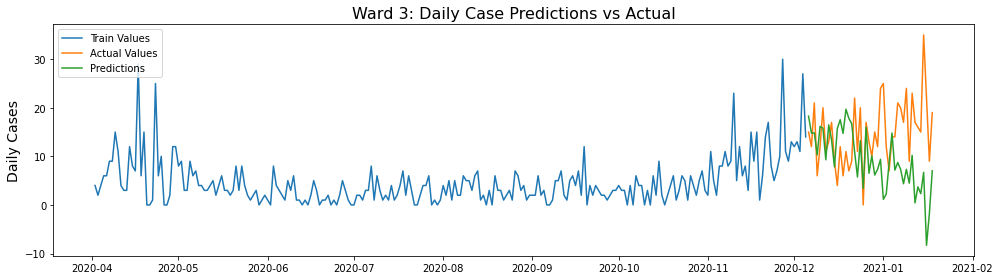

In [448]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 3, 
                  preds=undifferenced_preds)

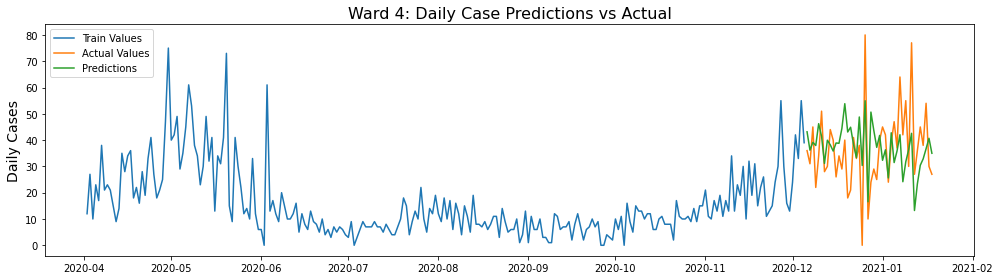

In [449]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 4, 
                  preds=undifferenced_preds)

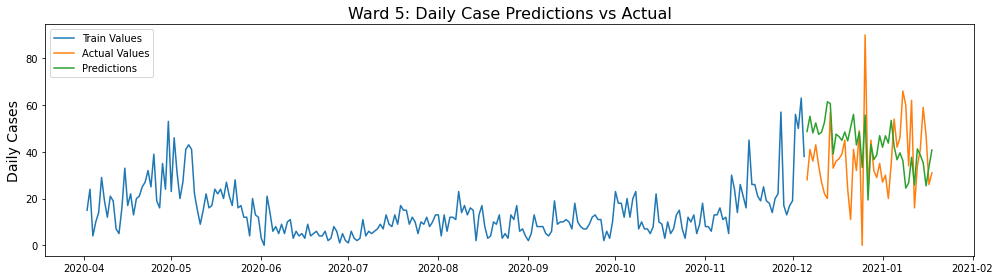

In [450]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 5, 
                  preds=undifferenced_preds)

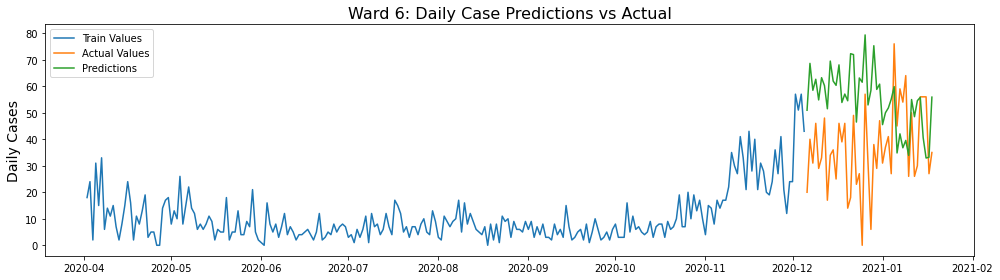

In [451]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 6, 
                  preds=undifferenced_preds)

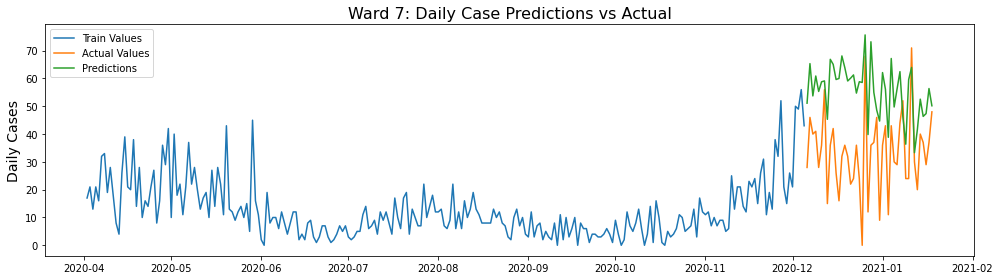

In [452]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 7, 
                  preds=undifferenced_preds)

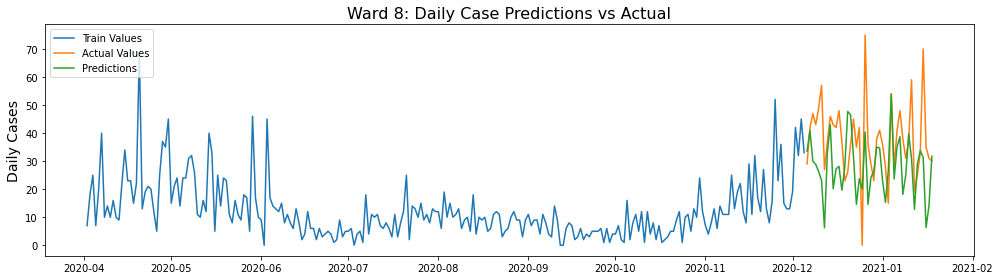

In [453]:
plot_test_vs_pred(train = train, 
                  test = test, 
                  ward_no= 8, 
                  preds=undifferenced_preds)